In [18]:
# PARTE RAQUEL

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import balanced_accuracy_score, f1_score
from cleanlab.filter import find_label_issues

In [138]:
folder = 'ML-water/'
df = pd.read_csv(folder+'AllData.csv', index_col='CVEGEO')
df_id = df[['NOM_ENT','NOM_MUN']].copy()
df = df.drop(columns=['NOM_ENT','NOM_MUN'])
df.head()

,POB_TOTAL,ALTITUD,AREA,UMBRAL12H,PORCENTA_1,urban,agua_AR,agua_FC,agua_PA,agua_PT,agua_PP,avg_impact,avg_agricultura,avg_construccion,avg_manufactura,avg_mineria,semaforo
CVEGEO,,,,,,,,,,,,,,,,,
1001,948990.0,1918.046196,116635.924756,57.80700,4.829056,3.0,91.0,226.0,2.0,24.0,0.0,0.900702,21.0,24.193751,44.979780,2.0,Rojo
1002,51536.0,2030.520325,54337.426602,60.05970,4.274541,0.0,0.0,54.0,1.0,9.0,0.0,0.904023,0.0,4.500000,2.083333,0.0,Verde
1003,58250.0,1827.143813,92335.783227,60.71769,1.158972,0.0,7.0,43.0,1.0,4.0,0.0,0.787156,3.0,2.333333,2.835498,1.0,Rojo
1004,17000.0,1967.656566,12838.354453,52.22142,3.153082,0.0,10.0,13.0,1.0,3.0,0.0,0.912407,0.0,0.000000,1.000000,0.0,Rojo
1005,129929.0,1936.513072,49989.509156,58.46688,3.357602,3.0,34.0,42.0,1.0,16.0,0.0,0.798126,3.0,23.113636,80.622222,106.0,Rojo


In [139]:
X_data = df.drop('semaforo',axis = 1)
y_data = df['semaforo']

In [140]:
print(len(y_data))
print(len(y_data[y_data.isna()]))
print(len(y_data)-len(y_data[y_data.isna()]))

2469
1423
1046


In [137]:
class RobustMultiModelNaNClassifier:
    def __init__(self, models=None, confidence_threshold=0.60, 
                 prediction_threshold=0.85, max_iterations=20):
        """
        Enhanced classifier that operates directly on 'semaforo' column.
        
        Args:
            models: List of classifier models (odd number recommended)
            confidence_threshold: Threshold for accepting ensemble predictions
            prediction_threshold: Threshold for keeping final predictions
            max_iterations: Maximum number of iterations
        """
        # Default robust models for noisy data
        if models is None:
            self.models = [
                CatBoostClassifier(iterations=500, class_weights={'Rojo': 0.31, 'Amarillo': 0.42, 'Verde': .27}, verbose=0),
                XGBClassifier(scale_pos_weight=2, max_depth=5, reg_alpha=1),
                RandomForestClassifier(max_samples=0.5, class_weight={'Rojo': 0.31, 'Amarillo': 0.42, 'Verde': .27})
            ]
        else:
            if len(models) % 2 == 0:
                raise ValueError("Number of models must be odd for voting")
            self.models = models
            
        self.confidence_threshold = confidence_threshold
        self.prediction_threshold = prediction_threshold
        self.max_iterations = max_iterations
        self.label_encoder = LabelEncoder()
        self.scaler = StandardScaler()
        self.fitted_models = []
        
    def _clean_data(self, X, y):
        """Remove outliers and likely mislabeled samples"""
        # 1. Remove feature outliers
        iso = IsolationForest(contamination=0.1, random_state=42)
        outliers = iso.fit_predict(X)
        clean_mask = outliers == 1
        
        # 2. Detect label issues (requires initial model)
        temp_model = RandomForestClassifier(max_samples=0.5)
        temp_model.fit(X[clean_mask], y[clean_mask])
        probas = temp_model.predict_proba(X[clean_mask])
        issues = find_label_issues(y[clean_mask], probas)
        
        return X[clean_mask][~issues], y[clean_mask][~issues]
    
    def fit(self, X, y):
        """Fit all models on cleaned and scaled training data"""
        # Clean data
        X_clean, y_clean = self._clean_data(X, y)
        
        # Scale numeric features
        X_scaled = self.scaler.fit_transform(X_clean)
        
        # Fit models
        self.fitted_models = []
        for model in self.models:
            try:
                model.fit(X_scaled, y_clean)
            except Exception as e:
                print(f"Error fitting {model.__class__.__name__}: {str(e)}")
                continue
            self.fitted_models.append(model)
    
    def predict_with_confidence(self, X):
        """
        Predict using ensemble of models with confidence.
        Returns predictions and confidence scores.
        """
        X_scaled = self.scaler.transform(X)
        
        all_probs = []
        for model in self.fitted_models:
            try:
                if hasattr(model, 'predict_proba'):
                    proba = model.predict_proba(X_scaled)
                else:  # For LinearSVC with CalibratedClassifierCV
                    proba = model.predict_proba(X_scaled)
                all_probs.append(proba)
            except Exception as e:
                print(f"Prediction error with {model.__class__.__name__}: {str(e)}")
                continue
                
        if not all_probs:
            raise ValueError("No models produced valid predictions")
        
        # Average probabilities across models
        avg_probs = np.mean(all_probs, axis=0)
        
        # Get predictions and confidence
        predictions = np.argmax(avg_probs, axis=1)
        confidence = np.max(avg_probs, axis=1)
        
        return predictions, confidence
    
    def process_dataframe(self, df):
        """
        Process the dataframe to predict NaN values in 'semaforo' column.
        Returns modified dataframe and iteration count.
        """
        # Validate input
        if 'semaforo' not in df.columns:
            raise ValueError("Dataframe must contain 'semaforo' column")
            
        # Make a working copy (we'll modify the 'semaforo' column directly)
        df_working = df.copy()
        
        # Add confidence column and set known labels to 1.0
        df_working['confidence'] = np.where(
            df_working['semaforo'].notna(), 
            1.0,  # Full confidence for known labels
            np.nan  # NaN for unknown labels
        )
        
        # Encode labels only if there are valid labels
        valid_mask = df_working['semaforo'].notna()
        if valid_mask.sum() == 0:
            raise ValueError("No valid labels found in 'semaforo' column")
        
        self.label_encoder.fit(df_working.loc[valid_mask, 'semaforo'])
        
        # Track which rows have been predicted
        predicted_mask = df_working['semaforo'].isna()
        iteration = 0
        
        while predicted_mask.any() and iteration < self.max_iterations:
            iteration += 1
            print(f"\nIteration {iteration}: {predicted_mask.sum()} NaN values remaining")
            
            # Prepare validation data (non-NaN rows)
            validation_df = df_working[~predicted_mask].copy()
            
            # Stratified split to maintain class balance
            train_df, test_df = train_test_split(
                validation_df, 
                test_size=0.2, 
                random_state=42 + iteration,
                stratify=validation_df['semaforo']
            )
            
            # Prepare features and target
            X_train = train_df.drop(columns=['semaforo', 'confidence'], errors='ignore')
            y_train = self.label_encoder.transform(train_df['semaforo'])
            
            X_test = test_df.drop(columns=['semaforo', 'confidence'], errors='ignore')
            y_test = test_df['semaforo']
            
            # Fit models
            self.fit(X_train, y_train)
            
            # Predict on test set with confidence
            test_pred_encoded, test_conf = self.predict_with_confidence(X_test)
            test_pred = self.label_encoder.inverse_transform(test_pred_encoded)
            
            # Calculate robust metrics
            test_bal_acc = balanced_accuracy_score(y_test, test_pred)
            test_f1 = f1_score(y_test, test_pred, average='weighted')
            avg_confidence = np.mean(test_conf)
            
            print(f"Test Balanced Accuracy: {test_bal_acc:.2f}")
            print(f"Test Weighted F1: {test_f1:.2f}")
            print(f"Avg Confidence: {avg_confidence:.2f}")
            
            # Only proceed if confidence threshold is met
            if avg_confidence < self.confidence_threshold:
                print("Confidence below threshold, stopping iteration")
                continue
                
            # Predict on NaN rows
            X_predict = df_working[predicted_mask].drop(
                columns=['semaforo', 'confidence'], 
                errors='ignore'
            )
            
            if not X_predict.empty:
                pred_encoded, pred_conf = self.predict_with_confidence(X_predict)
                pred_labels = self.label_encoder.inverse_transform(pred_encoded)
                
                # Update only high-confidence predictions
                high_conf_mask = pred_conf >= self.prediction_threshold
                
                if high_conf_mask.any():
                    # Update both the label and confidence
                    df_working.loc[predicted_mask, 'semaforo'] = np.where(
                        high_conf_mask,
                        pred_labels,
                        df_working.loc[predicted_mask, 'semaforo']
                    )
                    df_working.loc[predicted_mask, 'confidence'] = np.where(
                        high_conf_mask,
                        pred_conf,
                        df_working.loc[predicted_mask, 'confidence']
                    )
                
                # Update predicted mask
                predicted_mask = df_working['semaforo'].isna()
            else:
                print("No rows left to predict")
                
        # Final metrics
        num_predicted = (~df_working['semaforo'].isna() & (df_working['confidence'] < 1.0)).sum()
        avg_final_confidence = df_working.loc[df_working['confidence'] < 1.0, 'confidence'].mean()
        
        print(f"\nFinal Results:")
        print(f"- Predicted {num_predicted} values")
        print(f"- Average confidence of predictions: {avg_final_confidence:.2f}")
        
        if num_predicted > 0:
            # For evaluation, compare original known labels with current labels
            original_known_mask = df['semaforo'].notna()
            comparison_mask = original_known_mask & (df['semaforo'] != df_working['semaforo'])
            
            if comparison_mask.any():
                changed_count = comparison_mask.sum()
                change_accuracy = (df['semaforo'][comparison_mask] == df_working['semaforo'][comparison_mask]).mean()
                print(f"- Changed {changed_count} original labels")
                print(f"- Accuracy on changed labels: {change_accuracy:.2f}")
        
        return df_working, iteration

In [ ]:
classifier = RobustMultiModelNaNClassifier()
df_modified, iterations = classifier.process_dataframe(df)


Iteration 1: 1423 NaN values remaining
Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:47:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.51
Test Weighted F1: 0.52
Avg Confidence: 0.68

Iteration 2: 1192 NaN values remaining
Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:47:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.61
Test Weighted F1: 0.62
Avg Confidence: 0.74

Iteration 3: 890 NaN values remaining
Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:47:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.73
Test Weighted F1: 0.73
Avg Confidence: 0.81

Iteration 4: 658 NaN values remaining
Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:47:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.71
Test Weighted F1: 0.72
Avg Confidence: 0.82

Iteration 5: 505 NaN values remaining
Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:47:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.75
Test Weighted F1: 0.75
Avg Confidence: 0.83

Iteration 6: 412 NaN values remaining
Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:47:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.78
Test Weighted F1: 0.78
Avg Confidence: 0.83

Iteration 7: 359 NaN values remaining
Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:47:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.82
Test Weighted F1: 0.82
Avg Confidence: 0.86

Iteration 8: 319 NaN values remaining
Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.78
Test Weighted F1: 0.79
Avg Confidence: 0.85

Iteration 9: 294 NaN values remaining
Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.81
Test Weighted F1: 0.81
Avg Confidence: 0.85

Iteration 10: 268 NaN values remaining
Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.77
Test Weighted F1: 0.77
Avg Confidence: 0.84

Iteration 11: 246 NaN values remaining
Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.80
Test Weighted F1: 0.80
Avg Confidence: 0.85

Iteration 12: 223 NaN values remaining
Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.78
Test Weighted F1: 0.78
Avg Confidence: 0.83

Iteration 13: 208 NaN values remaining
Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.79
Test Weighted F1: 0.79
Avg Confidence: 0.84

Iteration 14: 193 NaN values remaining
Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.74
Test Weighted F1: 0.75
Avg Confidence: 0.84

Iteration 15: 184 NaN values remaining
Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.78
Test Weighted F1: 0.78
Avg Confidence: 0.85

Iteration 16: 173 NaN values remaining
Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.78
Test Weighted F1: 0.78
Avg Confidence: 0.84

Iteration 17: 162 NaN values remaining
Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:49:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.76
Test Weighted F1: 0.76
Avg Confidence: 0.83

Iteration 18: 156 NaN values remaining
Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:49:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.79
Test Weighted F1: 0.79
Avg Confidence: 0.84

Iteration 19: 149 NaN values remaining
Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:49:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.80
Test Weighted F1: 0.81
Avg Confidence: 0.84

Iteration 20: 144 NaN values remaining
Error fitting CatBoostClassifier: catboost/private/libs/target/target_converter.cpp:279: Not all class names are numeric, but specified target data is


/home/raqcoss/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:49:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Error fitting RandomForestClassifier: The classes, [0, 1, 2], are not in class_weight
Test Balanced Accuracy: 0.78
Test Weighted F1: 0.78
Avg Confidence: 0.84

Final Results:
- Predicted 1285 values
- Average confidence of predictions: 0.91


In [149]:
df_modified[df_modified['confidence']!=1]

,POB_TOTAL,ALTITUD,AREA,UMBRAL12H,PORCENTA_1,urban,agua_AR,agua_FC,agua_PA,agua_PT,agua_PP,avg_impact,avg_agricultura,avg_construccion,avg_manufactura,avg_mineria,semaforo,confidence
CVEGEO,,,,,,,,,,,,,,,,,,
1006,47646.0,1912.241007,1.957359e+04,58.23558,6.728276,0.0,2.0,19.0,1.0,2.0,0.0,0.836746,0.0,6.0,12.722222,0.0,Rojo,0.949542
1009,22485.0,1948.772727,2.296610e+04,55.62216,2.539697,0.0,9.0,18.0,1.0,1.0,1.0,0.871654,0.0,0.0,1.750000,1.0,Rojo,0.862390
1011,61997.0,1917.725191,1.377702e+04,57.86937,3.391930,3.0,9.0,27.0,1.0,7.0,0.0,0.891635,0.0,6.0,61.970213,0.0,Rojo,0.858121
2006,117568.0,145.451977,3.409724e+06,48.67578,1.004158,0.0,0.0,27.0,0.0,0.0,1.0,0.358984,47.0,3.5,2.029412,4.0,NaN,NaN
4010,31714.0,213.374074,1.394607e+06,105.91920,6.762152,0.0,0.0,19.0,1.0,0.0,0.0,0.543774,0.0,0.0,1.076923,0.0,Amarillo,0.867858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32028,2451.0,1497.860215,4.820085e+04,67.96404,1.511670,0.0,3.0,8.0,4.0,0.0,0.0,0.703315,0.0,0.0,1.000000,0.0,Rojo,0.891394
32031,8683.0,2082.835979,1.582976e+05,59.60943,1.461982,0.0,0.0,8.0,7.0,2.0,0.0,0.697977,0.0,6.0,1.100000,0.0,Verde,0.903966
32043,1365.0,2196.666667,1.974781e+04,57.66498,0.558261,0.0,2.0,4.0,4.0,1.0,0.0,0.626921,6.0,0.0,1.000000,0.0,Verde,0.962345


In [150]:
pred_geo = mun_geo.merge(df_modified, how = 'outer',left_index=True, right_index=True)
print(len(pred_geo))
pred_geo

2475


,geometry,POB_TOTAL,ALTITUD,AREA,UMBRAL12H,PORCENTA_1,urban,agua_AR,agua_FC,agua_PA,agua_PT,agua_PP,avg_impact,avg_agricultura,avg_construccion,avg_manufactura,avg_mineria,semaforo,confidence
CVEGEO,,,,,,,,,,,,,,,,,,,
1001,"POLYGON ((-102.09775 22.02325, -102.09857 22.0...",948990.0,1918.046196,116635.924756,57.80700,4.829056,3.0,91.0,226.0,2.0,24.0,0.0,0.900702,21.0,24.193751,44.979780,2.0,Rojo,1.00000
1002,"POLYGON ((-102.05189 22.29144, -102.05121 22.2...",51536.0,2030.520325,54337.426602,60.05970,4.274541,0.0,0.0,54.0,1.0,9.0,0.0,0.904023,0.0,4.500000,2.083333,0.0,Verde,1.00000
1003,"POLYGON ((-102.57625 21.96778, -102.57626 21.9...",58250.0,1827.143813,92335.783227,60.71769,1.158972,0.0,7.0,43.0,1.0,4.0,0.0,0.787156,3.0,2.333333,2.835498,1.0,Rojo,1.00000
1004,"POLYGON ((-102.2532 22.37449, -102.2532 22.374...",17000.0,1967.656566,12838.354453,52.22142,3.153082,0.0,10.0,13.0,1.0,3.0,0.0,0.912407,0.0,0.000000,1.000000,0.0,Rojo,1.00000
1005,"POLYGON ((-102.31034 22.03716, -102.31034 22.0...",129929.0,1936.513072,49989.509156,58.46688,3.357602,3.0,34.0,42.0,1.0,16.0,0.0,0.798126,3.0,23.113636,80.622222,106.0,Rojo,1.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32054,"POLYGON ((-101.65599 22.51381, -101.65586 22.5...",19446.0,2167.903226,37142.598661,58.41954,5.038430,0.0,11.0,31.0,1.0,3.0,0.0,0.794049,0.0,0.000000,2.000000,0.0,Rojo,1.00000
32055,"POLYGON ((-102.69428 22.6223, -102.69476 22.62...",31558.0,1962.535211,215650.560215,61.17057,3.174213,0.0,4.0,10.0,1.0,2.0,0.0,0.726474,46.0,0.000000,3.076923,3.0,Rojo,1.00000
32056,"POLYGON ((-102.58542 22.81149, -102.58541 22.8...",149607.0,2263.314961,43682.101048,60.79104,3.129201,3.0,5.0,22.0,1.0,2.0,0.0,0.785869,0.0,13.555556,9.888060,191.0,Rojo,1.00000


ValueError: alpha must be between 0 and 1, inclusive, but min is -0.4070031796182907, max is -0.25714285714285734

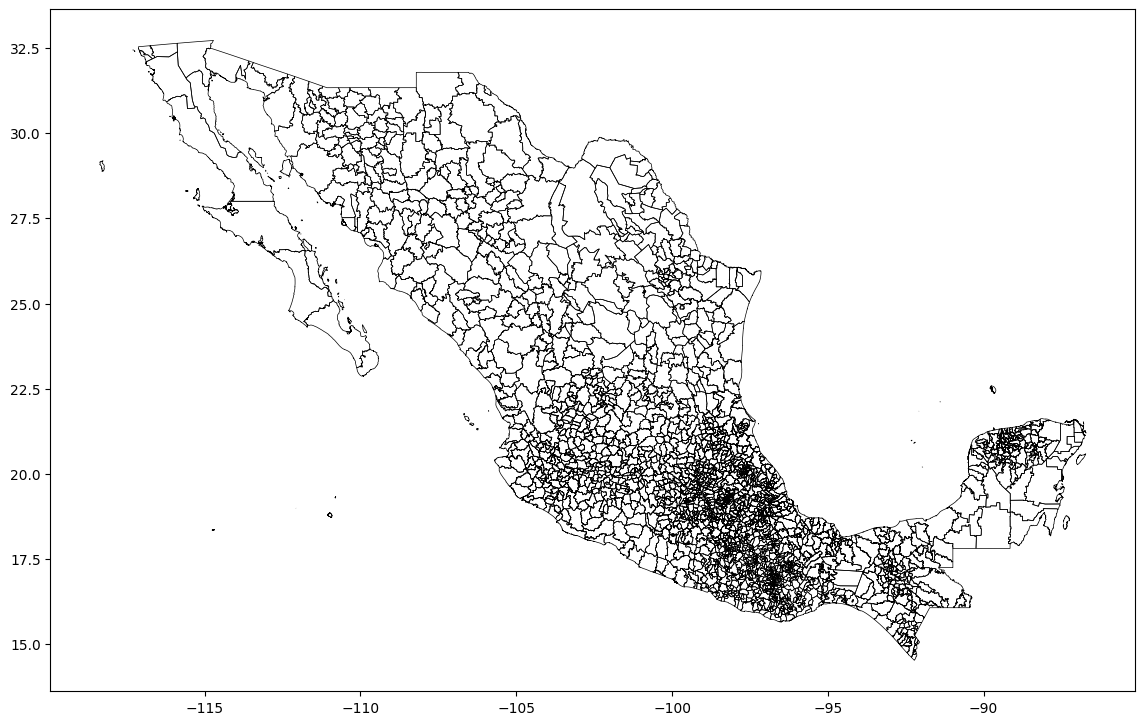

In [157]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Define color mapping
color_map = {
    'Rojo': 'red',
    'Amarillo': 'gold',
    'Verde': 'green'
}

# Create figure and axis
fig, ax = plt.subplots(figsize=(14, 10))

# 1. First plot all geometries with full opacity (for borders)
pred_geo.boundary.plot(ax=ax, color='black', linewidth=0.5)

# 2. Create a new column for plotting colors
pred_geo['plot_color'] = pred_geo['semaforo'].map(color_map).fillna('gray')

# 3. Plot with confidence-based alpha
for class_name in color_map.keys():
    # Filter features for this class
    class_data = pred_geo[pred_geo['semaforo'] == class_name]
    if not class_data.empty:
        # Plot with variable alpha
        class_data.plot(
            ax=ax,
            color=class_data['plot_color'],
            alpha=class_data['confidence'].fillna(0)-.88/0.7,  # Use confidence for alpha
            edgecolor='none',
            label=class_name
        )

# 4. Create custom legend
legend_elements = []
for class_name, color in color_map.items():
    legend_elements.append(mpatches.Patch(
        color=color,
        label=class_name,
        alpha=1.0
    ))

# Add confidence explanation
confidence_elements = [
    mpatches.Patch(color='black', alpha=0.3, label='Low Confidence (30%)'),
    mpatches.Patch(color='black', alpha=0.6, label='Medium Confidence (60%)'),
    mpatches.Patch(color='black', alpha=0.9, label='High Confidence (90%)')
]

ax.legend(
    handles=legend_elements + confidence_elements,
    title='Semaforo Classes & Confidence',
    loc='upper right'
)

plt.title('Semaforo Classification with Confidence-Based Transparency')
plt.tight_layout()
plt.show()

<Axes: >

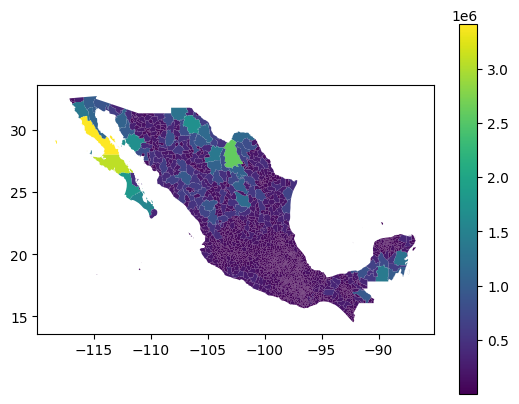

In [66]:
# Division política de México por municipios
import geopandas as gpd # For .shp and .geoJSON files
import matplotlib.pyplot as plt
municipios_path = '/home/raqcoss/Shared/Notebook/Machine Learning/WATER/datasets/mun22gw/mun22gw.shp'
municipios = gpd.read_file(municipios_path)
municipios.plot(column = 'AREA',legend = True)



,geometry
CVEGEO,
1008,"POLYGON ((-102.35385 22.12064, -102.35426 22.1..."
1009,"POLYGON ((-102.16213 22.34851, -102.16149 22.3..."
1010,"POLYGON ((-101.89778 21.95839, -101.89037 21.9..."
1011,"POLYGON ((-102.14088 22.07534, -102.14086 22.0..."
1001,"POLYGON ((-102.09775 22.02325, -102.09857 22.0..."
...,...
32014,"POLYGON ((-102.89148 24.46084, -102.88558 24.4..."
32043,"POLYGON ((-103.10931 22.57209, -103.11083 22.5..."
32045,"POLYGON ((-103.1586 21.63311, -103.15928 21.63..."


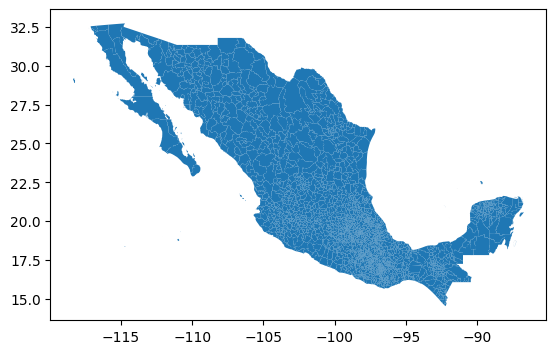

In [92]:
municipios['CVEGEO'] = municipios['CVEGEO'].astype(int)
mun_geo = municipios[['CVEGEO','geometry']].set_index('CVEGEO')
mun_geo.plot()
mun_geo

In [143]:
df_predicted

,POB_TOTAL,ALTITUD,AREA,UMBRAL12H,PORCENTA_1,urban,agua_AR,agua_FC,agua_PA,agua_PT,agua_PP,avg_impact,avg_agricultura,avg_construccion,avg_manufactura,avg_mineria,semaforo,semaforo_pred,pred_confidence
CVEGEO,,,,,,,,,,,,,,,,,,,
1001,948990.0,1918.046196,116635.924756,57.80700,4.829056,3.0,91.0,226.0,2.0,24.0,0.0,0.900702,21.0,24.193751,44.979780,2.0,Rojo,NaN,NaN
1002,51536.0,2030.520325,54337.426602,60.05970,4.274541,0.0,0.0,54.0,1.0,9.0,0.0,0.904023,0.0,4.500000,2.083333,0.0,Verde,NaN,NaN
1003,58250.0,1827.143813,92335.783227,60.71769,1.158972,0.0,7.0,43.0,1.0,4.0,0.0,0.787156,3.0,2.333333,2.835498,1.0,Rojo,NaN,NaN
1004,17000.0,1967.656566,12838.354453,52.22142,3.153082,0.0,10.0,13.0,1.0,3.0,0.0,0.912407,0.0,0.000000,1.000000,0.0,Rojo,NaN,NaN
1005,129929.0,1936.513072,49989.509156,58.46688,3.357602,3.0,34.0,42.0,1.0,16.0,0.0,0.798126,3.0,23.113636,80.622222,106.0,Rojo,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32054,19446.0,2167.903226,37142.598661,58.41954,5.038430,0.0,11.0,31.0,1.0,3.0,0.0,0.794049,0.0,0.000000,2.000000,0.0,Rojo,NaN,NaN
32055,31558.0,1962.535211,215650.560215,61.17057,3.174213,0.0,4.0,10.0,1.0,2.0,0.0,0.726474,46.0,0.000000,3.076923,3.0,Rojo,NaN,NaN
32056,149607.0,2263.314961,43682.101048,60.79104,3.129201,3.0,5.0,22.0,1.0,2.0,0.0,0.785869,0.0,13.555556,9.888060,191.0,Rojo,NaN,NaN


In [144]:
pred_geo = mun_geo.merge(df_predicted, how = 'outer',left_index=True, right_index=True)
print(len(pred_geo))
pred_geo


2475


,geometry,POB_TOTAL,ALTITUD,AREA,UMBRAL12H,PORCENTA_1,urban,agua_AR,agua_FC,agua_PA,agua_PT,agua_PP,avg_impact,avg_agricultura,avg_construccion,avg_manufactura,avg_mineria,semaforo,semaforo_pred,pred_confidence
CVEGEO,,,,,,,,,,,,,,,,,,,,
1001,"POLYGON ((-102.09775 22.02325, -102.09857 22.0...",948990.0,1918.046196,116635.924756,57.80700,4.829056,3.0,91.0,226.0,2.0,24.0,0.0,0.900702,21.0,24.193751,44.979780,2.0,Rojo,NaN,NaN
1002,"POLYGON ((-102.05189 22.29144, -102.05121 22.2...",51536.0,2030.520325,54337.426602,60.05970,4.274541,0.0,0.0,54.0,1.0,9.0,0.0,0.904023,0.0,4.500000,2.083333,0.0,Verde,NaN,NaN
1003,"POLYGON ((-102.57625 21.96778, -102.57626 21.9...",58250.0,1827.143813,92335.783227,60.71769,1.158972,0.0,7.0,43.0,1.0,4.0,0.0,0.787156,3.0,2.333333,2.835498,1.0,Rojo,NaN,NaN
1004,"POLYGON ((-102.2532 22.37449, -102.2532 22.374...",17000.0,1967.656566,12838.354453,52.22142,3.153082,0.0,10.0,13.0,1.0,3.0,0.0,0.912407,0.0,0.000000,1.000000,0.0,Rojo,NaN,NaN
1005,"POLYGON ((-102.31034 22.03716, -102.31034 22.0...",129929.0,1936.513072,49989.509156,58.46688,3.357602,3.0,34.0,42.0,1.0,16.0,0.0,0.798126,3.0,23.113636,80.622222,106.0,Rojo,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32054,"POLYGON ((-101.65599 22.51381, -101.65586 22.5...",19446.0,2167.903226,37142.598661,58.41954,5.038430,0.0,11.0,31.0,1.0,3.0,0.0,0.794049,0.0,0.000000,2.000000,0.0,Rojo,NaN,NaN
32055,"POLYGON ((-102.69428 22.6223, -102.69476 22.62...",31558.0,1962.535211,215650.560215,61.17057,3.174213,0.0,4.0,10.0,1.0,2.0,0.0,0.726474,46.0,0.000000,3.076923,3.0,Rojo,NaN,NaN
32056,"POLYGON ((-102.58542 22.81149, -102.58541 22.8...",149607.0,2263.314961,43682.101048,60.79104,3.129201,3.0,5.0,22.0,1.0,2.0,0.0,0.785869,0.0,13.555556,9.888060,191.0,Rojo,NaN,NaN


<Axes: >

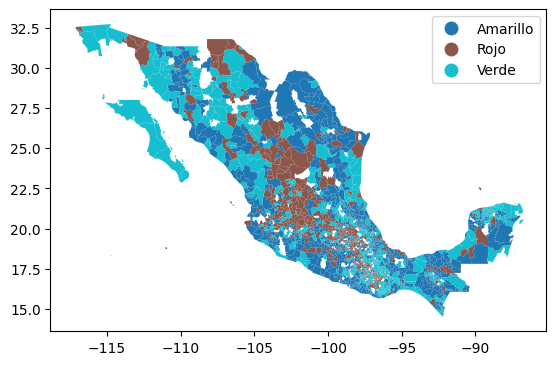

In [151]:
pred_geo.plot(column = 'semaforo', legend= True)

<Axes: >

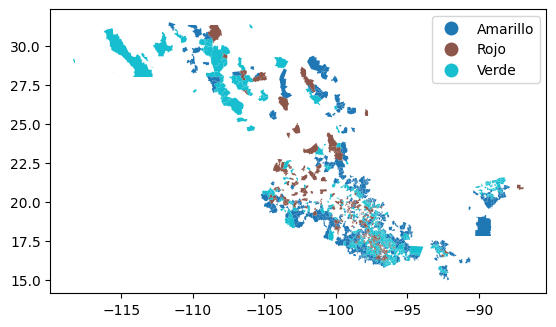

In [146]:
pred_geo.plot(column = 'semaforo_pred', legend= True)

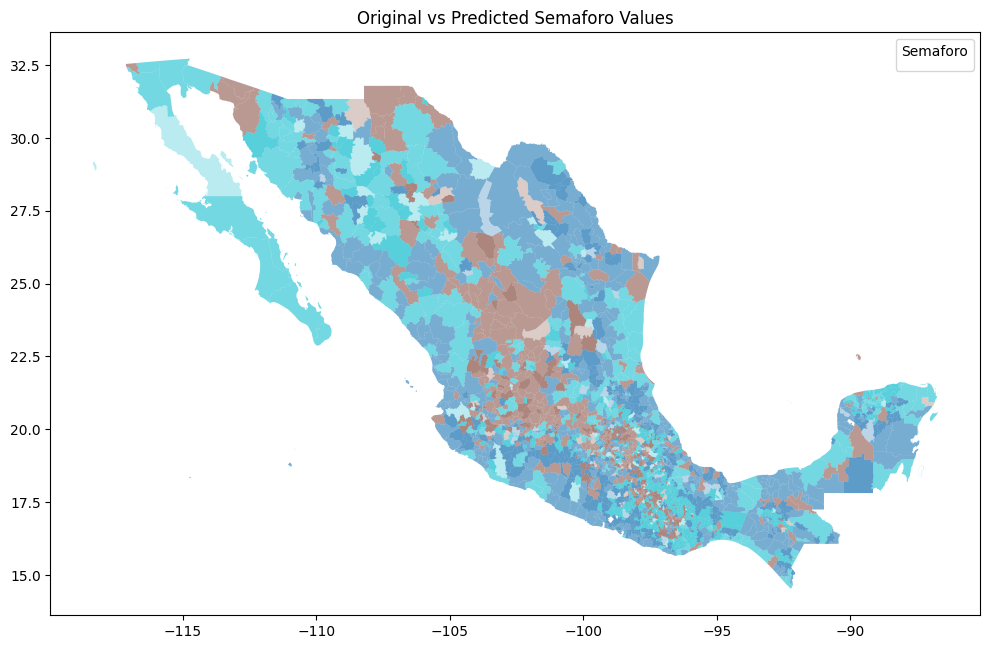

In [136]:
import matplotlib.pyplot as plt

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Plot predicted values first (with transparency)
pred_geo.plot(column='semaforo_pred', 
              alpha=0.3,  # Set transparency
             legend=True,
              ax=ax)

# Plot original values on top (solid colors)
pred_geo.plot(column='semaforo',
              alpha=.6,  # Solid (no transparency)
              legend=False,  # We'll use one legend
              ax=ax)

# Customize legend
handles, labels = ax.get_legend_handles_labels()
# Only keep one set of legend items (remove duplicates)
unique_labels = []
unique_handles = []
for handle, label in zip(handles, labels):
    if label not in unique_labels:
        unique_labels.append(label)
        unique_handles.append(handle)
        
ax.legend(unique_handles, unique_labels, title='Semaforo')

# Add title
plt.title('Original vs Predicted Semaforo Values')
plt.show()

In [120]:
pred_geo[pred_geo].plot(column = 'pred_confidence', legend= True)

ValueError: Boolean array expected for the condition, not geometry

In [121]:

predicted_data = df_predicted.reset_index().merge(municipios[['CVEGEO','geometry']], on = 'CVEGEO', how='outer')
predicted_data

,CVEGEO,POB_TOTAL,ALTITUD,AREA,UMBRAL12H,PORCENTA_1,urban,agua_AR,agua_FC,agua_PA,...,agua_PP,avg_impact,avg_agricultura,avg_construccion,avg_manufactura,avg_mineria,semaforo,semaforo_pred,pred_confidence,geometry
0,1001,948990.0,1918.046196,116635.924756,57.80700,4.829056,3.0,91.0,226.0,2.0,...,0.0,0.900702,21.0,24.193751,44.979780,2.0,Rojo,NaN,NaN,"POLYGON ((-102.09775 22.02325, -102.09857 22.0..."
1,1002,51536.0,2030.520325,54337.426602,60.05970,4.274541,0.0,0.0,54.0,1.0,...,0.0,0.904023,0.0,4.500000,2.083333,0.0,Verde,NaN,NaN,"POLYGON ((-102.05189 22.29144, -102.05121 22.2..."
2,1003,58250.0,1827.143813,92335.783227,60.71769,1.158972,0.0,7.0,43.0,1.0,...,0.0,0.787156,3.0,2.333333,2.835498,1.0,Rojo,NaN,NaN,"POLYGON ((-102.57625 21.96778, -102.57626 21.9..."
3,1004,17000.0,1967.656566,12838.354453,52.22142,3.153082,0.0,10.0,13.0,1.0,...,0.0,0.912407,0.0,0.000000,1.000000,0.0,Rojo,NaN,NaN,"POLYGON ((-102.2532 22.37449, -102.2532 22.374..."
4,1005,129929.0,1936.513072,49989.509156,58.46688,3.357602,3.0,34.0,42.0,1.0,...,0.0,0.798126,3.0,23.113636,80.622222,106.0,Rojo,NaN,NaN,"POLYGON ((-102.31034 22.03716, -102.31034 22.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2470,32054,19446.0,2167.903226,37142.598661,58.41954,5.038430,0.0,11.0,31.0,1.0,...,0.0,0.794049,0.0,0.000000,2.000000,0.0,Rojo,NaN,NaN,"POLYGON ((-101.65599 22.51381, -101.65586 22.5..."
2471,32055,31558.0,1962.535211,215650.560215,61.17057,3.174213,0.0,4.0,10.0,1.0,...,0.0,0.726474,46.0,0.000000,3.076923,3.0,Rojo,NaN,NaN,"POLYGON ((-102.69428 22.6223, -102.69476 22.62..."
2472,32056,149607.0,2263.314961,43682.101048,60.79104,3.129201,3.0,5.0,22.0,1.0,...,0.0,0.785869,0.0,13.555556,9.888060,191.0,Rojo,NaN,NaN,"POLYGON ((-102.58542 22.81149, -102.58541 22.8..."
2473,32057,20455.0,2136.738095,21844.700672,55.98486,3.752207,3.0,8.0,9.0,1.0,...,0.0,0.843648,0.0,0.000000,2.100000,0.0,Verde,NaN,NaN,"POLYGON ((-102.2461 22.73451, -102.24615 22.73..."
